In [93]:
import networkx as nx
from thewalrus import hafnian
from tqdm import tqdm
import numpy as np
import random 
import matplotlib.pyplot as plt
import copy

# 设置全局字体为 Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({"font.size": 16})

# 启用 LaTeX 渲染
plt.rcParams["text.usetex"] = True
# Number of vertexes
n = 256

# @Rui graph-1 for 80-densest subgraph: vertex i has edges to vertices 0, 1, …, n-1-i
adj_matrix = np.zeros((n, n), dtype=int) 
for i in range(n):
    adj_matrix[i, :n-i] = 1
    adj_matrix[i, i] = 0
# Make sure the matrix is symmetric since it's an undirected graph
adj_matrix = np.triu(adj_matrix) + np.triu(adj_matrix, 1).T
G1 = nx.from_numpy_array(adj_matrix)
np.save(f"./Data/{n}/G1.npy", nx.to_numpy_array(G1))

# @Rui graph-2 for finding 12-subgraph with max-hafnian: containing 12-complete graph and remaining edge with probability 0.2
G2 = nx.Graph()
np.random.seed(7)

# Select 12 nodes to form a complete subgraph
nodes_to_connect = list(range(n))
np.random.shuffle(nodes_to_connect)
complete_subgraph_nodes = nodes_to_connect[:16]
G2.add_nodes_from(range(n)) 
G2.add_edges_from(nx.complete_graph(complete_subgraph_nodes).edges())
# Randomly select the remaining edges with probability 0.2
for i in range(n):
    for j in range(i+1, n):
        if (i in complete_subgraph_nodes and j in complete_subgraph_nodes) or np.random.rand() >= 0.2:
            continue
        G2.add_edge(i, j)
np.save(f"./Data/{n}/G2.npy", nx.to_numpy_array(G2))

def calculate_hafnian(subgraph):
    # Convert the subgraph to an adjacency matrix
    adj_matrix = nx.to_numpy_array(subgraph)
    return abs(hafnian(adj_matrix))

print(hafnian(nx.to_numpy_array(nx.complete_graph(16)))) # Complex number

def calculate_density(subgraph):
    # Calculate the density of the subgraph
    num_nodes = subgraph.number_of_nodes()
    num_edges = subgraph.number_of_edges()
    if num_nodes < 2:
        return 0  # Avoid division by zero
    density = num_edges / num_nodes
    return density

print(calculate_density(G2))

(2027025+0j)
26.61328125


In [5]:
# Initial matching is empty set
def glauber_dynamics(G, k, c, mixing_time):
    matching = set()
    post_select_subgraph = list()
    
    for _ in range(mixing_time):
        # Randomly select an edge
        e = random.choice(list(G.edges()))
        u, v = e
        # Check the status of the selected edge
        if all(node not in list(n for edge in matching for n in edge) for node in e):
            # Both u and v are not in the matching
            if np.random.rand() <= c**2 / (1 + c**2):
                matching.add(e)
        elif e in matching:
            # Both u and v are in the matching
            if np.random.rand() <= 1 / (1 + c**2):
                matching.remove(e)
        
        # Check if the matching is a k-subgraph
        if 2 * len(matching) == k:
            post_select_subgraph.append(G.subgraph(G.edge_subgraph(matching).nodes()))
        
    return post_select_subgraph[-1]

def jerrum_glauber_dynamics(G, k, c, mixing_time):
    # Initial matching is an empty set
    matching = set()
    post_select_subgraph = list()

    for _ in range(mixing_time):
        # Select an edge uniformly at random
        e = random.choice(list(G.edges))
        u, v = e

        # Check the status of the selected edge
        flag = 0
        nodes = set()
        for edge in matching:
            n1, n2 = edge
            nodes.add(n1)
            nodes.add(n2)
        if (u in nodes) or (v in nodes):
            flag = 1
        if (u in nodes) and (v in nodes):
            flag = 2
        # update
        if flag == 0:
            new_matching = matching | {e}
        elif flag == 1:
            for edge in matching:
                if (u in edge) or (v in edge):
                    alternative_edge = edge
                    new_matching = (matching - {alternative_edge}) | {e}
                    break
        else:
            if e in matching:
                new_matching = matching - {e}
            else:
                new_matching = matching

        # Calculate acceptance probability
        old_weight = c ** (2*len(matching))
        new_weight = c ** (2*len(new_matching))
        acceptance_probability = min(1, new_weight / old_weight)

        # Accept or reject the new matching
        if random.random() < acceptance_probability:
            matching = new_matching
        
        # Check if the matching is a k-subgraph
        if 2 * len(matching) == k:
            post_select_subgraph.append(G.subgraph(G.edge_subgraph(matching).nodes()))

    return post_select_subgraph[-1]

def quantum_inspired_sampling(G, k):
    A = nx.adjacency_matrix(G).toarray()
    # Construct the diagonal-dominant matrix
    for i in range(n):
        for j in range(n):
            if not(j==i):
                A[i][i]+=abs(A[i][j])
                
    # Function to create the vector b^(ij) from A_ij  
    def create_b_ij(A, i, j):
        b_ij = np.zeros(A.shape[0])  # M-dimensional vector
        b_ij[i] = np.sqrt(A[i, j])
        b_ij[j] = np.sqrt(A[i, j])
        return b_ij

    # Construct the matrix H
    M = A.shape[0]  # Matrix dimension (M x M)
    H = np.zeros((M, M * M))  # H is M x M^2 matrix

    # Fill the matrix H as per the given description
    for i in range(M):
        for j in range(i + 1, M):
            b_ij = create_b_ij(A, i, j)
            column_index = M * i + j  # Column index in H
            H[:, column_index] = b_ij
        
    # Construct the diagonal matrix D
    D_diag = np.sum(H, axis=0) 
    D = np.diag(D_diag)  

    # Construct the matrix V
    V = np.zeros_like(H)  
    for i in range(H.shape[1]):
        if D_diag[i] > 0:  # Avoid division by zero
            V[:, i] = H[:, i] / D_diag[i]
        else:
            V[:, i] = 0  # Set the column to zero if D_ii = 0

    trace = np.sum(D_diag ** 2)
    Q = np.diag(D_diag **2) / trace
    
    # Verify that A = HH^T
    A_reconstructed = V @ D @ D @ V.T

    row_indices = []
    while len(row_indices) < k:
        row_indices = []
        selected_columns = np.random.choice(len(D_diag), size= k//2, replace=True, p= D_diag **2/trace)
        
        # Get the row indices of the non-zero elements in the selected columns
        for col in selected_columns:
            non_zero_indices = np.nonzero(V[:, col])[0]  # Get the row indices of non-zero elements
            row_indices.extend(non_zero_indices)  # Add the row indices to the list
        
        # remove duplicates
        row_indices = list(set(row_indices))
        
    return G.subgraph(row_indices)

In [2]:
def random_search(G, k, iteration):
    nodes = list(G.nodes)
    Best = 0
    AB_subgraph = None
    List = [Best]
    
    for _ in range(iteration):
        # Choose Ai, a k-d submatrix of A, randomly
        Ai = random.sample(nodes, k)
        Ai_subgraph = G.subgraph(Ai)
        f_Ai = calculate_hafnian(Ai_subgraph)
        
        if f_Ai > Best:
            Best = f_Ai
            AB_subgraph = Ai_subgraph
        List.append(Best)
        
    return List, AB_subgraph, Best

def glauber_random_search(G, k, c, iteration, mixing_time):
    nodes = list(G.nodes)
    Best = 0
    AB_subgraph = None
    List = [Best]
    
    for _ in range(iteration):
        # Choose Ai, a k-d of A by Glauber Dynamics
        Ai_subgraph = glauber_dynamics(G, k, c, mixing_time)
        f_Ai = calculate_hafnian(Ai_subgraph)
        
        if f_Ai > Best:
            Best = f_Ai
            AB_subgraph = Ai_subgraph
        List.append(Best)
        
    return List, AB_subgraph, Best

def jerrum_glauber_random_search(G, k, c, iteration, mixing_time):
    nodes = list(G.nodes)
    Best = 0
    AB_subgraph = None
    List = [Best]
    
    for _ in range(iteration):
        # Choose Ai, a k-d of A by Glauber Dynamics
        Ai_subgraph = jerrum_glauber_dynamics(G, k, c, mixing_time)
        f_Ai = calculate_hafnian(Ai_subgraph)
        
        if f_Ai > Best:
            Best = f_Ai
            AB_subgraph = Ai_subgraph
        List.append(Best)
        
    return List, AB_subgraph, Best

def quantum_inspired_random_search(G, k, iteration):
    nodes = list(G.nodes)
    Best = 0
    AB_subgraph = None
    List = [Best]
    
    for _ in range(iteration):
        # Choose Ai, a k-d of A by Glauber Dynamics
        Ai_subgraph = quantum_inspired_sampling(G, k)
        f_Ai = calculate_hafnian(Ai_subgraph)
        
        if f_Ai > Best:
            Best = f_Ai
            AB_subgraph = Ai_subgraph
        List.append(Best)
        
    return List, AB_subgraph, Best

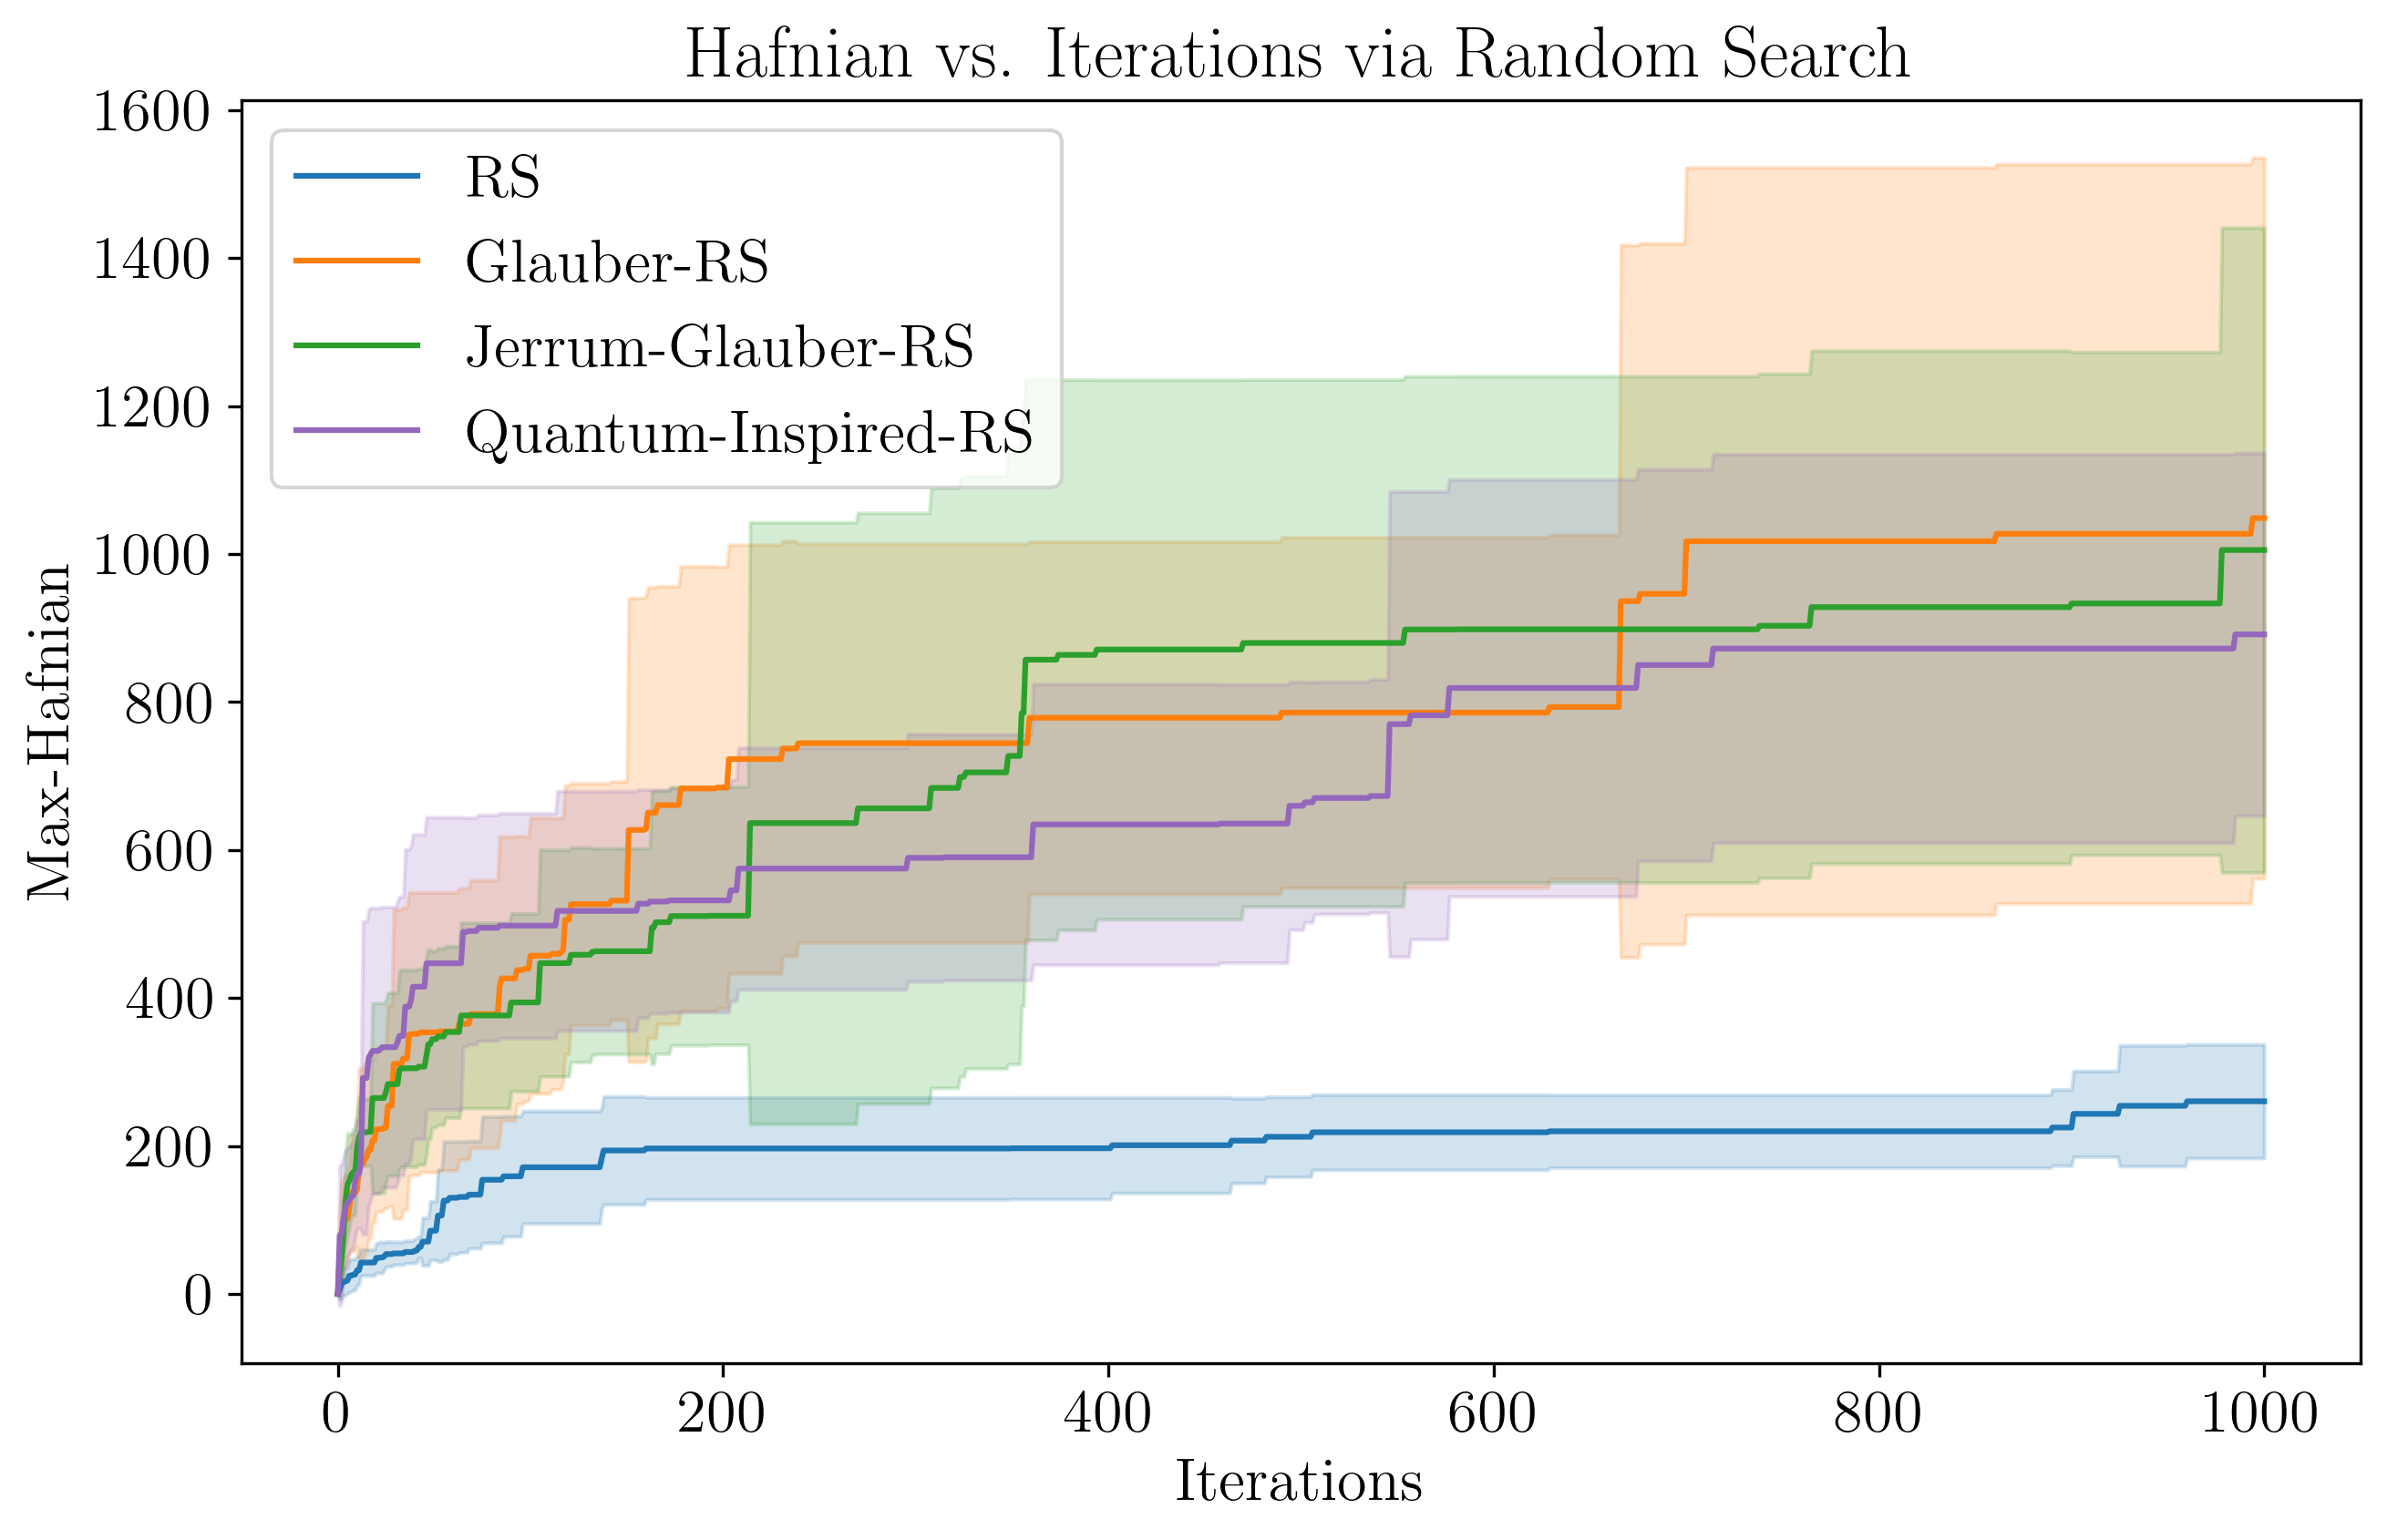

In [ ]:
# Plot the max-Hafnian values of the 12-node subgraph with the maximum Hafnian using Random Search
G = G2
c = 0.1 # fugacity
k = 16
iteration = 1000
mixing_time = 10000
plt.figure(figsize=(10, 6), dpi=300)

# Finding the 12-node subgraph with the maximum Hafnian using Random Search
max_hafnian_list = np.zeros((10, iteration+1))
for i in tqdm(range(10)):
    max_hafnian_list[i], best_subgraph, best_hafnian = random_search(G, k, iteration)

np.save(f"./Data/{n}/RS_hafnian_list.npy", max_hafnian_list)
mean_hafnian_values = np.mean(max_hafnian_list, axis=0)
std_hafnian_values = np.std(max_hafnian_list, axis=0)

plt.plot(mean_hafnian_values, label="RS", color='C0')
plt.fill_between(range(iteration+1), mean_hafnian_values - std_hafnian_values, mean_hafnian_values + std_hafnian_values, color = 'C0', alpha=0.2)

# Finding the 12-node subgraph with the maximum Hafnian using Glauber Random Search
glauber_max_hafnian_list = np.zeros((10, iteration+1))
for i in tqdm(range(10)):
    glauber_max_hafnian_list[i], glauber_best_subgraph, glauber_best_hafnian = glauber_random_search(G, k, c, iteration, mixing_time)

np.save(f"./Data/{n}/glauber_RS_hafnian_list.npy", glauber_max_hafnian_list)
mean_glauber_hafnian_values = np.mean(glauber_max_hafnian_list, axis=0)
std_glauber_hafnian_values = np.std(glauber_max_hafnian_list, axis=0)

plt.plot(mean_glauber_hafnian_values, label="Glauber-RS", color='C1')
plt.fill_between(range(iteration+1), mean_glauber_hafnian_values - std_glauber_hafnian_values, mean_glauber_hafnian_values + std_glauber_hafnian_values, color = 'C1', alpha=0.2)

# Finding the 12-node subgraph with the maximum Hafnian using Jerrum Glauber Random Search
jerrum_glauber_max_hafnian_list = np.zeros((10, iteration+1))
for i in tqdm(range(10)):
    jerrum_glauber_max_hafnian_list[i], jerrum_glauber_best_subgraph, jerrum_glauber_best_hafnian = jerrum_glauber_random_search(G, k, c, iteration, mixing_time)

np.save(f"./Data/{n}/jerrum_glauber_RS_hafnian_list.npy", jerrum_glauber_max_hafnian_list)
mean_jerrum_glauber_hafnian_values = np.mean(jerrum_glauber_max_hafnian_list, axis=0)
std_jerrum_glauber_hafnian_values = np.std(jerrum_glauber_max_hafnian_list, axis=0)

plt.plot(mean_jerrum_glauber_hafnian_values, label="Jerrum-Glauber-RS", color='C2')
plt.fill_between(range(iteration+1), mean_jerrum_glauber_hafnian_values - std_jerrum_glauber_hafnian_values, mean_jerrum_glauber_hafnian_values + std_jerrum_glauber_hafnian_values, color = 'C2', alpha=0.2)
 
# Finding the 12-node subgraph with the maximum Hafnian using Quantum Inspired Random Search
quantum_inspired_max_hafnian_list = np.zeros((10, iteration+1))
for i in tqdm(range(10)):
    quantum_inspired_max_hafnian_list[i], quantum_inspired_best_subgraph, quantum_inspired_best_hafnian = quantum_inspired_random_search(G, k, iteration)

np.save(f"./Data/{n}/quantum_inspired_RS_hafnian_list.npy", quantum_inspired_max_hafnian_list)
mean_quantum_inspired_hafnian_values = np.mean(quantum_inspired_max_hafnian_list, axis=0)
std_quantum_inspired_hafnian_values = np.std(quantum_inspired_max_hafnian_list, axis=0)

plt.plot(mean_quantum_inspired_hafnian_values, label="Quantum-Inspired-RS", color='C4')
plt.fill_between(range(iteration+1), mean_quantum_inspired_hafnian_values - std_quantum_inspired_hafnian_values, mean_quantum_inspired_hafnian_values + std_quantum_inspired_hafnian_values, color = 'C4', alpha=0.2)

plt.xlabel("Iterations")
plt.ylabel("Max-Hafnian")
plt.title("Hafnian vs. Iterations via Random Search")
plt.legend(loc = 'upper left')
plt.savefig("./Figure/hafnian_random_search.pdf")
plt.show()

In [4]:
def simulated_annealing(G, k, iteration, t_initial):
    nodes = list(G.nodes)
    # Randomly generate a binary vector S with k entries being nonzero
    S = np.zeros(len(nodes))
    S[:k] = 1
    np.random.shuffle(S)
    AS_nodes = np.where(S == 1)[0]
    AS_subgraph = G.subgraph(AS_nodes)
    AB_subgraph = AS_subgraph
    Best = calculate_hafnian(AS_subgraph)
    List = [Best]
    
    t = t_initial
    for _ in range(iteration):
        
        # Generate an integer m in [0, k-1]
        m = random.randint(0, k-1)

        #  Shuffle m nonzero entries of S
        nonzero_indices = np.where(S == 1)[0]
        zero_indices = np.where(S == 0)[0]
        # Find the indices of the entries that are not shuffled
        fixed_indices = random.sample(list(nonzero_indices), m)
        remaining_indices = list(set(nonzero_indices) - set(fixed_indices)) + list(zero_indices)
        random.shuffle(remaining_indices)
        
        # Construct a new binary vector R
        R = np.zeros(n, dtype=int)
        R[fixed_indices] = 1
        R[remaining_indices[:k-m]] = 1

        # Construct the subgraph AR
        AR_nodes = np.where(R == 1)[0]
        AR_subgraph = G.subgraph(AR_nodes)

        f_AR = calculate_hafnian(AR_subgraph)
        f_AS = calculate_hafnian(AS_subgraph)
        
        if f_AR > f_AS:
            if f_AR > Best:
                Best = f_AR
                AB_subgraph = AR_subgraph
            S = R
            AS_subgraph = AR_subgraph  # Update A_S
            
        else:
            if np.random.rand() < np.exp((f_AR - f_AS) / t):
                S = R
                AS_subgraph = AR_subgraph  # Update A_S
        
        List.append(Best)
        # Decrease t
        t *= 0.95
    
    return List, AB_subgraph, Best

def glauber_simulated_annealing(G, k, c, iteration, mixing_time, t_initial):
    nodes = list(G.nodes)
    # Initialize S by Glauber Dynamics
    S = np.zeros(len(nodes))
    initial = list(glauber_dynamics(G, k, c, mixing_time).nodes)
    S[initial] = 1
    AS_nodes = np.where(S == 1)[0]
    AS_subgraph = G.subgraph(AS_nodes)
    AB_subgraph = AS_subgraph
    Best = calculate_hafnian(AS_subgraph)
    List = [Best]
    
    t = t_initial
    for _ in range(iteration):
        # Original from scratch search AR_subgraph = glauber_dynamics(G, k, c, mixing_time)
        # Generate an integer m in [0, k-1]
        m = random.randint(0, k-1)  
        
        nonzero_indices = np.where(S == 1)[0]
        zero_indices = np.where(S == 0)[0]
        s = set(random.sample(list(nonzero_indices), m)) # fixed indices
        
        # Glauber Dynamics until S and R has no intersection
        r = set(glauber_dynamics(G, k, c, mixing_time).nodes)
        intersection = s & r
        r = r - intersection
        r = r - set(random.sample(list(r), m - len(intersection)))
        
        AR_subgraph = G.subgraph(s | r)  
          
        R = np.zeros(len(nodes))
        for i in range(len(nodes)):
            if i in list(AR_subgraph.nodes):
                R[i] = 1
    
        f_AR = calculate_hafnian(AR_subgraph)
        f_AS = calculate_hafnian(AS_subgraph)
        
        if f_AR > f_AS:
            if f_AR > Best:
                Best = f_AR
                AB_subgraph = AR_subgraph
            S = R
            AS_subgraph = AR_subgraph  # Update A_S
        else:
            if random.random() < np.exp((f_AR - f_AS) / t):
                S = R
                AS_subgraph = AR_subgraph  # Update A_S
        
        List.append(Best)
        # Decrease t
        t *= 0.95
    
    return List, AB_subgraph, Best

def jerrum_glauber_simulated_annealing(G, k, c, iteration, mixing_time, t_initial):
    nodes = list(G.nodes)
    # Initialize S by Glauber Dynamics
    S = np.zeros(len(nodes))
    initial = list(jerrum_glauber_dynamics(G, k, c, mixing_time).nodes)
    S[initial] = 1
    AS_nodes = np.where(S == 1)[0]
    AS_subgraph = G.subgraph(AS_nodes)
    AB_subgraph = AS_subgraph
    Best = calculate_hafnian(AS_subgraph)
    List = [Best]
    
    t = t_initial
    for _ in range(iteration):
        # Original from scratch search AR_subgraph = glauber_dynamics(G, k, c, mixing_time)
        # Generate an integer m in [0, k-1]
        m = random.randint(0, k-1)  
        
        nonzero_indices = np.where(S == 1)[0]
        zero_indices = np.where(S == 0)[0]
        s = set(random.sample(list(nonzero_indices), m)) # fixed indices
        
        # Glauber Dynamics until S and R has no intersection
        r = set(jerrum_glauber_dynamics(G, k, c, mixing_time).nodes)
        intersection = s & r
        r = r - intersection
        r = r - set(random.sample(list(r), m - len(intersection)))
        
        AR_subgraph = G.subgraph(s | r)
            
        R = np.zeros(len(nodes))
        for i in range(len(nodes)):
            if i in list(AR_subgraph.nodes):
                R[i] = 1
        f_AR = calculate_hafnian(AR_subgraph)
        f_AS = calculate_hafnian(AS_subgraph)
        
        if f_AR > f_AS:
            if f_AR > Best:
                Best = f_AR
                AB_subgraph = AR_subgraph
            S = R
            AS_subgraph = AR_subgraph  # Update A_S
        else:
            if random.random() < np.exp((f_AR - f_AS) / t):
                S = R
                AS_subgraph = AR_subgraph  # Update A_S
        
        List.append(Best)
        # Decrease t
        t *= 0.95
    
    return List, AB_subgraph, Best

def quantum_inspired_simulated_annealing(G, k, iteration, t_initial):
    nodes = list(G.nodes)
    # Initialize S by Glauber Dynamics
    S = np.zeros(len(nodes))
    initial = list(quantum_inspired_sampling(G, k).nodes)
    S[initial] = 1
    AS_nodes = np.where(S == 1)[0]
    AS_subgraph = G.subgraph(AS_nodes)
    AB_subgraph = AS_subgraph
    Best = calculate_hafnian(AS_subgraph)
    List = [Best]
    
    t = t_initial
    for _ in range(iteration):
        # Original from scratch search AR_subgraph = glauber_dynamics(G, k, c, mixing_time)
        # Generate an integer m in [0, k-1]
        m = random.randint(0, k-1)  
        
        nonzero_indices = np.where(S == 1)[0]
        zero_indices = np.where(S == 0)[0]
        s = set(random.sample(list(nonzero_indices), m)) # fixed indices
        
        # Glauber Dynamics until S and R has no intersection
        r = set(quantum_inspired_sampling(G, k).nodes)
        intersection = s & r
        r = r - intersection
        r = r - set(random.sample(list(r), m - len(intersection)))
        
        AR_subgraph = G.subgraph(s | r)
            
        R = np.zeros(len(nodes))
        for i in range(len(nodes)):
            if i in list(AR_subgraph.nodes):
                R[i] = 1
        f_AR = calculate_hafnian(AR_subgraph)
        f_AS = calculate_hafnian(AS_subgraph)
        
        if f_AR > f_AS:
            if f_AR > Best:
                Best = f_AR
                AB_subgraph = AR_subgraph
            S = R
            AS_subgraph = AR_subgraph  # Update A_S
        else:
            if random.random() < np.exp((f_AR - f_AS) / t):
                S = R
                AS_subgraph = AR_subgraph  # Update A_S
        
        List.append(Best)
        # Decrease t
        t *= 0.95
    
    return List, AB_subgraph, Best

100%|██████████| 10/10 [81:35:47<00:00, 29374.77s/it]  


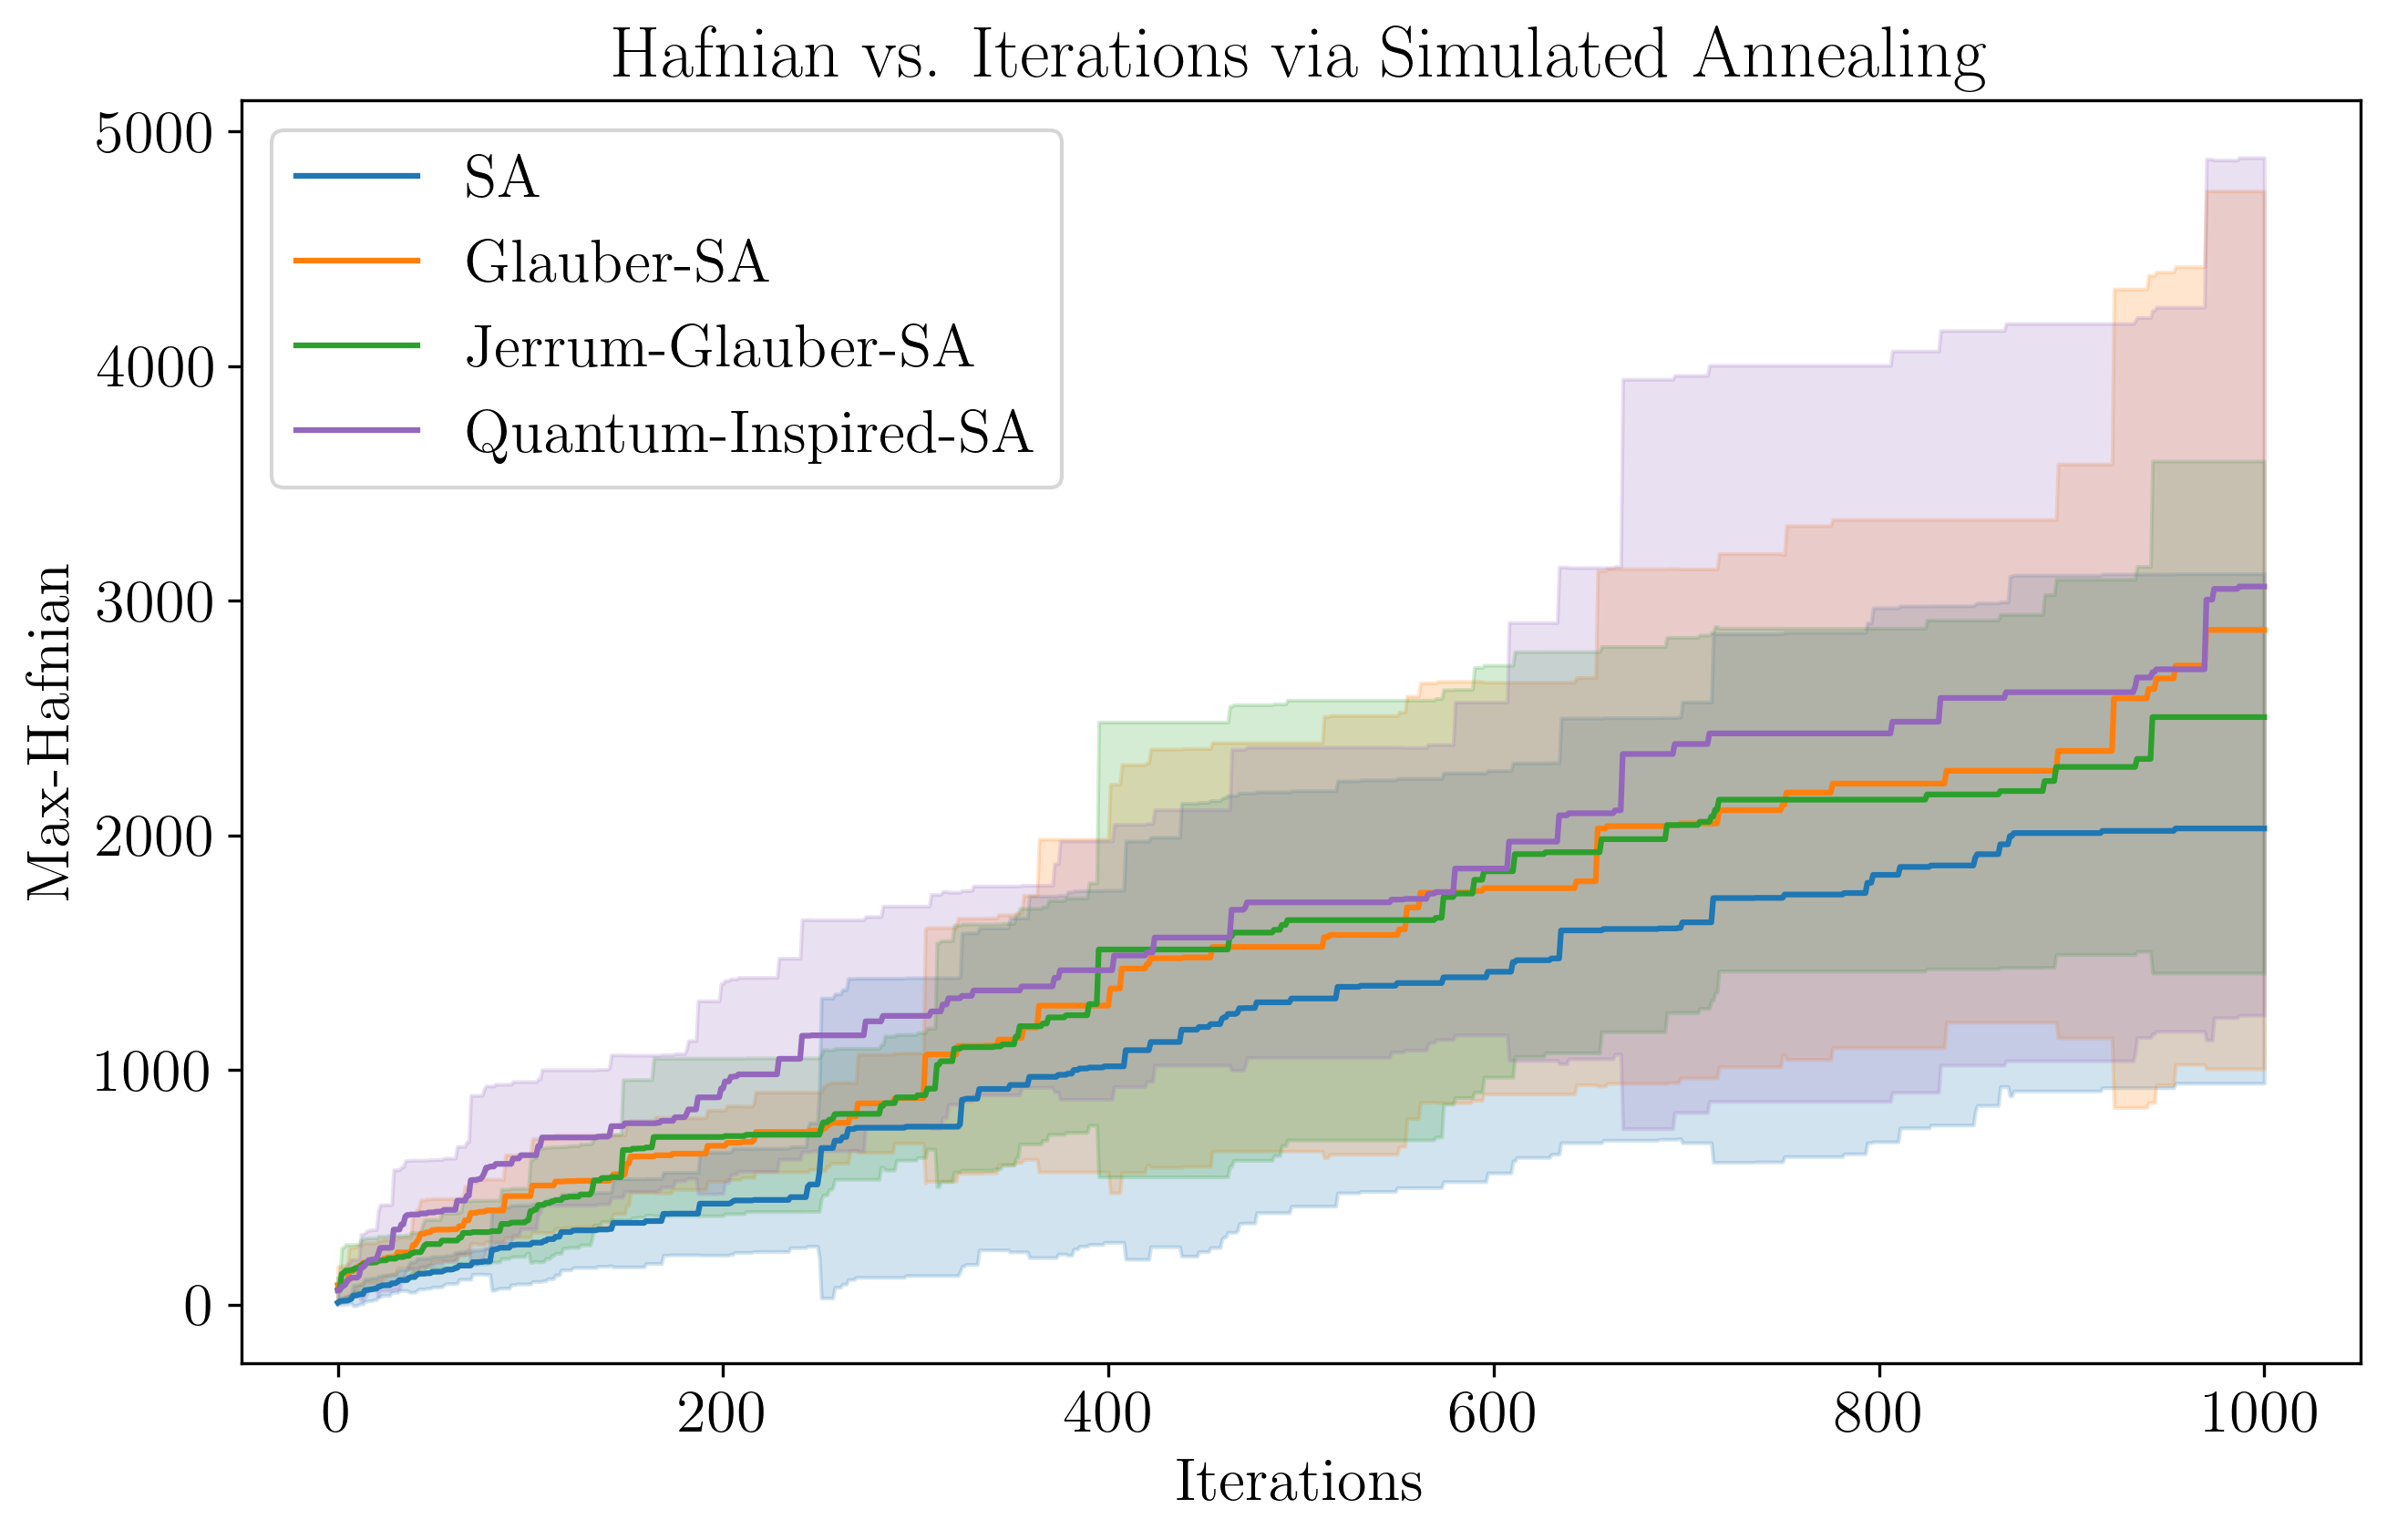

In [5]:
# Plot the max-Hafnian values of the 12-node subgraph with the maximum Hafnian using Simulated Annealing
G= G2
c = 0.1 # fugacity
k = 16
iteration = 1000
mixing_time = 10000
t_initial = 1.0
plt.figure(figsize=(10, 6), dpi=300)

# Finding the 12-node subgraph with the maximum Hafnian using Simulated Annealing
max_hafnian_list = np.zeros((10, iteration+1))
for i in tqdm(range(10)):
    max_hafnian_list[i], best_subgraph, best_hafnian = simulated_annealing(G, k, iteration, t_initial)

np.save(f"./Data/{n}/SA_hafnian_list.npy", max_hafnian_list)
mean_hafnian_values = np.mean(max_hafnian_list, axis=0)
std_hafnian_values = np.std(max_hafnian_list, axis=0)

plt.plot(mean_hafnian_values, label="SA", color='C0')
plt.fill_between(range(iteration+1), mean_hafnian_values - std_hafnian_values, mean_hafnian_values + std_hafnian_values, color='C0', alpha=0.2)

# Finding the 12-node subgraph with the maximum Hafnian using Glauber Simulated Annealing
glauber_max_hafnian_list = np.zeros((10, iteration+1))
for i in tqdm(range(10)):
    glauber_max_hafnian_list[i], glauber_best_subgraph, glauber_best_hafnian = glauber_simulated_annealing(G, k, c, iteration, mixing_time, t_initial)

np.save(f"./Data/{n}/glauber_SA_hafnian_list.npy", glauber_max_hafnian_list)
mean_glauber_hafnian_values = np.mean(glauber_max_hafnian_list, axis=0)
std_glauber_hafnian_values = np.std(glauber_max_hafnian_list, axis=0)

plt.plot(mean_glauber_hafnian_values, label="Glauber-SA", color='C1')
plt.fill_between(range(iteration+1), mean_glauber_hafnian_values - std_glauber_hafnian_values, mean_glauber_hafnian_values + std_glauber_hafnian_values, color = 'C1', alpha=0.2)

# Finding the 12-node subgraph with the maximum Hafnian using Jerrum Glauber Simulated Annealing
jerrum_glauber_max_hafnian_list = np.zeros((10, iteration+1))
for i in tqdm(range(10)):
    jerrum_glauber_max_hafnian_list[i], jerrum_glauber_best_subgraph, jerrum_glauber_best_hafnian = jerrum_glauber_simulated_annealing(G, k, c, iteration, mixing_time, t_initial)

np.save(f"./Data/{n}/jerrum_glauber_SA_hafnian_list.npy", jerrum_glauber_max_hafnian_list)
mean_jerrum_glauber_hafnian_values = np.mean(jerrum_glauber_max_hafnian_list, axis=0)
std_jerrum_glauber_hafnian_values = np.std(jerrum_glauber_max_hafnian_list, axis=0)

plt.plot(mean_jerrum_glauber_hafnian_values, label="Jerrum-Glauber-SA", color='C2')
plt.fill_between(range(iteration+1), mean_jerrum_glauber_hafnian_values - std_jerrum_glauber_hafnian_values, mean_jerrum_glauber_hafnian_values + std_jerrum_glauber_hafnian_values, color = 'C2', alpha=0.2)

# Finding the 12-node subgraph with the maximum Hafnian using Quantum Inspired Simulated Annealing
quantum_inspired_max_hafnian_list = np.zeros((10, iteration+1))
for i in tqdm(range(10)):
    quantum_inspired_max_hafnian_list[i], quantum_inspired_best_subgraph, quantum_inspired_best_hafnian = quantum_inspired_simulated_annealing(G, k, iteration, t_initial)

np.save(f"./Data/{n}/quantum_inspired_SA_hafnian_list.npy", quantum_inspired_max_hafnian_list)
mean_quantum_inspired_hafnian_values = np.mean(quantum_inspired_max_hafnian_list, axis=0)
std_quantum_inspired_hafnian_values = np.std(quantum_inspired_max_hafnian_list, axis=0)

plt.plot(mean_quantum_inspired_hafnian_values, label="Quantum-Inspired-SA", color='C4')
plt.fill_between(range(iteration+1), mean_quantum_inspired_hafnian_values - std_quantum_inspired_hafnian_values, mean_quantum_inspired_hafnian_values + std_quantum_inspired_hafnian_values, color = 'C4', alpha=0.2)

plt.xlabel("Iterations")
plt.ylabel("Max-Hafnian")
plt.title("Hafnian vs. Iterations via Simulated Annealing")
plt.legend(loc = 'upper left')
plt.savefig("./Figure/hafnian_simulated_annealing.pdf")
plt.show()